In [91]:
import os, time, segyio
from time import time
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.model_selection import train_test_split
from skimage.metrics import structural_similarity
from sklearn.metrics import r2_score, mean_squared_error as mse_metric, mean_absolute_error as mae_metric
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

import tensorflow as tf
import keras.backend as K
from keras import Model, Input
from keras.layers import *
from keras.optimizers import *
from keras.losses import *

In [5]:
def check_tf_gpu():
    sys_info = tf.sysconfig.get_build_info()
    version, cuda, cudnn = tf.__version__, sys_info["cuda_version"], sys_info["cudnn_version"]
    count = len(tf.config.experimental.list_physical_devices())
    name  = [device.name for device in tf.config.experimental.list_physical_devices('GPU')]
    print('-'*60)
    print('----------------------- VERSION INFO -----------------------')
    print('TF version: {} | # Device(s) available: {}'.format(version, count))
    print('TF Built with CUDA? {} | CUDA: {} | cuDNN: {}'.format(tf.test.is_built_with_cuda(), cuda, cudnn))
    print(tf.config.list_physical_devices()[0],'\n', tf.config.list_physical_devices()[1])
    print('-'*60+'\n')
    return None

def plot_loss(data, figsize=(6,4)):
    plt.figure(figsize=figsize)
    plt.plot(data.history['loss'], label='train')
    plt.plot(data.history['val_loss'], label='validation')
    plt.legend(); plt.grid(True, which='both')
    plt.xlabel('Epochs'); plt.ylabel('Loss')
    plt.tight_layout()
    plt.show()
    return None

In [6]:
check_tf_gpu()

------------------------------------------------------------
----------------------- VERSION INFO -----------------------
TF version: 2.19.0 | # Device(s) available: 2
TF Built with CUDA? True | CUDA: 12.5.1 | cuDNN: 9
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU') 
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
------------------------------------------------------------



In [7]:
# slb_flat = np.moveaxis(segyio.tools.cube(segyio.open('Schlumberger Synthetic models/Schlumberger_800_SLB_Force_Fault_Model_Flat_Noisy_Amplitude.segy')), -1, 1)
# slb_hybrid = np.moveaxis(segyio.tools.cube(segyio.open('Schlumberger Synthetic models/Schlumberger_800_SLB_Force_Fault_Model_Hybrid_Noisy_Amplitude.segy')), -1, 1)
# slb_circular = np.moveaxis(segyio.tools.cube(segyio.open('Schlumberger Synthetic models/Schlumberger_800_SLB_Force_Fault_Model_Circular_Noisy_Amplitude.segy')), -1, 1)
# slb_fault = np.moveaxis(segyio.tools.cube(segyio.open('Schlumberger Synthetic models/Schlumberger_800_SLB_Force_Fault_Model_IsFault.segy')), -1, 1)
# print('Flat: {} | Hybrid: {} | Circular: {} | Fault: {}'.format(slb_flat.shape, slb_hybrid.shape, slb_circular.shape, slb_fault.shape))

# my_cmap = 'seismic'
# fig, axs = plt.subplots(3, 10, figsize=(20,6), sharex=True, sharey=True)
# for j in range(10):
#     k = j * 10
#     ax1, ax2, ax3 = axs[0,j], axs[1,j], axs[2,j]
#     ax1.imshow(slb_flat[k], cmap=my_cmap)
#     ax2.imshow(slb_hybrid[k], cmap=my_cmap)
#     ax3.imshow(slb_circular[k], cmap=my_cmap)
#     [a.imshow(slb_fault[k], cmap='binary', alpha=0.4) for a in axs[:,j]]
#     [a.set(xticks=[], yticks=[], title='Slice {}'.format(k) if i==0 else '') for i, a in enumerate(axs[:, j])]
#     [a.set_ylabel(['Flat','Hybrid','Circular'][i], color='k') for i, a in enumerate(axs[:,0])]
# plt.tight_layout()
# plt.show()

PP: (101, 751, 589) | AI: (101, 751, 589) | Fault: (101, 751, 589)


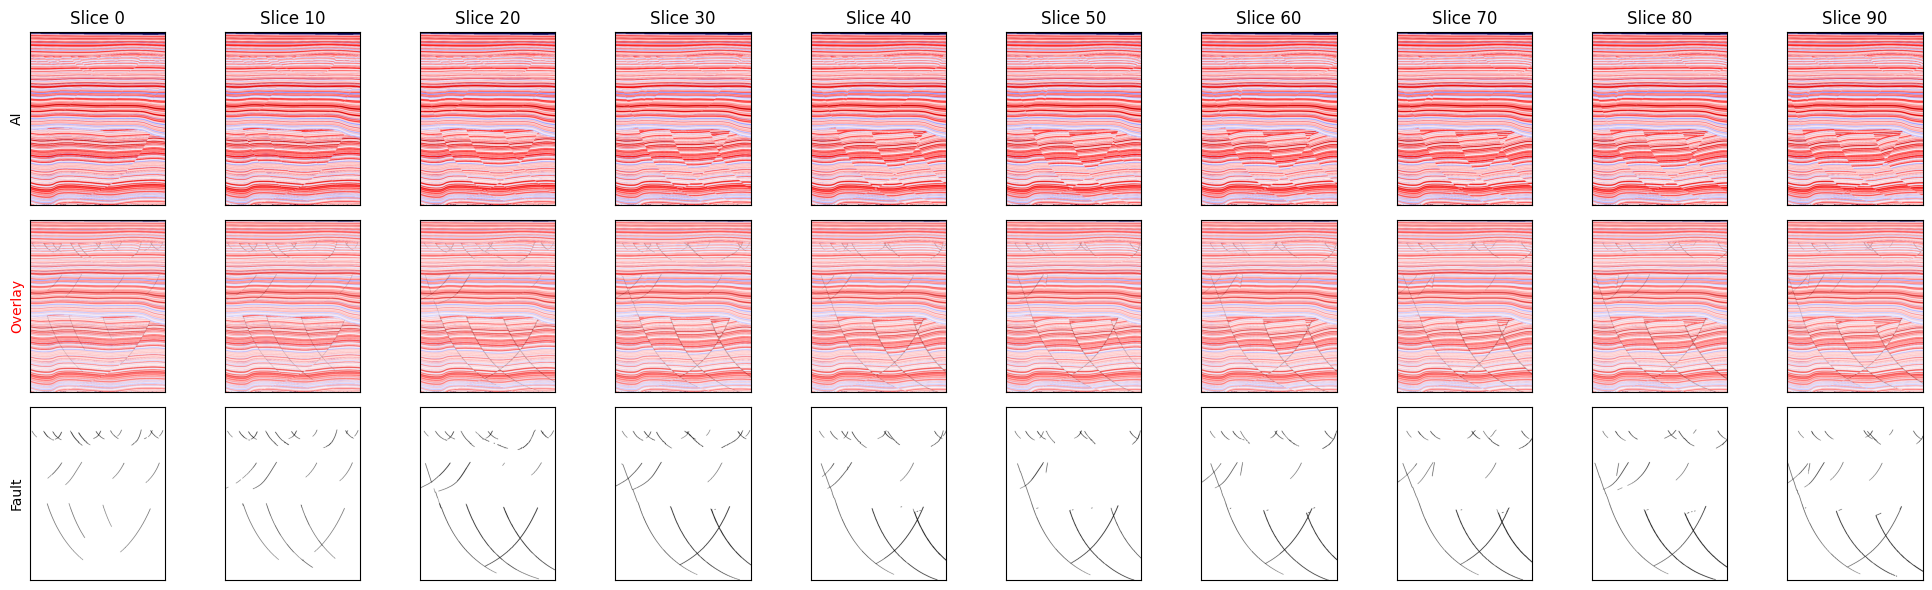

In [8]:
equinor_pp = np.rot90(segyio.tools.cube(segyio.open('Equinor Synthetic model/issap20_Pp.sgy', xline=181)), axes=(1,2), k=3)
equinor_ai = np.rot90(segyio.tools.cube(segyio.open('Equinor Synthetic model/issap20_AI.sgy', xline=181)), axes=(1,2), k=3)
equinor_fault = np.rot90(segyio.tools.cube(segyio.open('Equinor Synthetic model/issap20_Fault.sgy', xline=181)), axes=(1,2), k=3)
print('PP: {} | AI: {} | Fault: {}'.format(equinor_pp.shape, equinor_ai.shape, equinor_fault.shape))

fig, axs = plt.subplots(3, 10, figsize=(20, 6), sharex=True, sharey=True)
for j in range(10):
    k = j * 10
    ax1, ax2, ax3 = axs[0, j], axs[1, j], axs[2, j]
    ax1.imshow(equinor_ai[k], cmap='seismic')
    ax2.imshow(equinor_ai[k], cmap='seismic')
    ax2.imshow(equinor_fault[k], cmap='binary', alpha=0.25)
    ax3.imshow(equinor_fault[k], cmap='binary')
    [a.set(xticks=[], yticks=[], title='Slice {}'.format(k) if i==0 else '') for i, a in enumerate(axs[:, j])]
    [a.set_ylabel(['AI','Overlay','Fault'][i], color=['k','r','k'][i]) for i, a in enumerate(axs[:,0])]
plt.tight_layout()
plt.show()

In [74]:
# reshape
X_data = np.moveaxis(np.pad(equinor_ai, ((0,0),(8,9),(0,0)), mode='constant', constant_values=0)[:,:,38:-39].reshape(-1, 3, 256, 512).reshape(-1,256,256,2), -1, 1).reshape(-1,256,256,1)
Y_data = np.moveaxis(np.pad(equinor_fault, ((0,0),(8,9),(0,0)), mode='constant', constant_values=0)[:,:,38:-39].reshape(-1, 3, 256, 512).reshape(-1,256,256,2), -1, 1).reshape(-1,256,256,1)

# normalize
X_data = (X_data - X_data.min()) / (X_data.max() - X_data.min())
Y_data = (Y_data - Y_data.min()) / (Y_data.max() - Y_data.min())

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.174)
n_train, n_test = X_train.shape[0], X_test.shape[0]
print('Train - X: {} | Y: {}\nTest  - X: {} | Y: {}'.format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

Train - X: (500, 256, 256, 1) | Y: (500, 256, 256, 1)
Test  - X: (106, 256, 256, 1) | Y: (106, 256, 256, 1)


In [ ]:
def make_model():
    def conv_block(inp, filt, kern=(3,3), pool=(2,2), pad='same'):
        _ = Conv2D(filters=filt, kernel_size=kern, padding=pad)(inp)
        _ = BatchNormalization()(_)
        _ = Activation('relu')(_)
        _ = MaxPooling2D(pool_size=pool)(_)
        return _
    
    def deconv_block(inp, filt, kern=(3,3), pool=(2,2), pad='same'):
        _ = Conv2D(filters=filt, kernel_size=kern, padding=pad)(inp)
        _ = BatchNormalization()(_)
        _ = Activation('relu')(_)
        _ = UpSampling2D(size=pool)(_)
        return _
    
    inp = Input(shape=(None,None,1))
    # encoder
    x = conv_block(inp, 16)
    x = conv_block(x, 64)
    x = conv_block(x, 128)
    x = conv_block(x, 256)
    # decoder
    x = deconv_block(x, 256)
    x = deconv_block(x, 128)
    x = deconv_block(x, 64)
    x = deconv_block(x, 16)
    # model
    out = SeparableConv2D(filters=1, kernel_size=(3,3), padding='same')(x)
    return Model(inp, out, name='faultAE')    

# of paramters: 1,350,481
Training time: 1.39 min


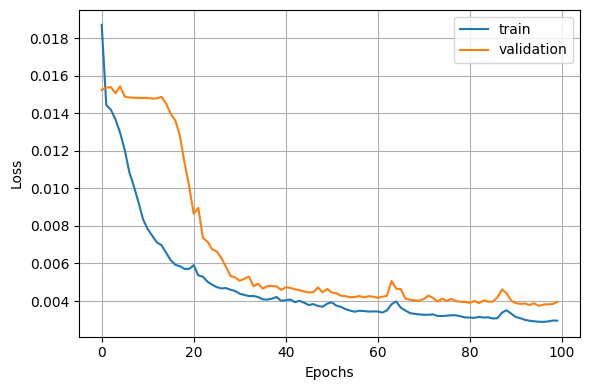

In [50]:
ae = make_model()
print('# of paramters: {:,}'.format(ae.count_params()))
ae.compile(optimizer=Adam(1e-3), metrics=['mse'], loss=MeanSquaredError())
start = time()
fit = ae.fit(x=X_train, y=y_train,
             epochs = 100,
             batch_size = 16,
             validation_split = 0.2,
             shuffle = True,
             verbose = 0)
print('Training time: {:.2f} min'.format((time()-start)/60))
plot_loss(fit)

In [75]:
y_train_pred = ae.predict(X_train, verbose=0).squeeze()
y_test_pred = ae.predict(X_test, verbose=0).squeeze()

y_train_pred = (y_train_pred - y_train_pred.min()) / (y_train_pred.max() - y_train_pred.min())
y_test_pred = (y_test_pred - y_test_pred.min()) / (y_test_pred.max() - y_test_pred.min())

y_train_pred = np.where(y_train_pred > 0.5, 1, 0)
y_test_pred = np.where(y_test_pred > 0.5, 1, 0)

print('Pred - train: {} | test: {}'.format(y_train_pred.shape, y_test_pred.shape))
print('Train - min: {:.3f} | max: {:.3f} | mean: {:.3f}'.format(y_train_pred.min(), y_train_pred.max(), y_train_pred.mean()))
print('Test  - min: {:.3f} | max: {:.3f} | mean: {:.3f}'.format(y_test_pred.min(), y_test_pred.max(), y_test_pred.mean()))

Pred - train: (500, 256, 256) | test: (106, 256, 256)
Train - min: 0.000 | max: 1.000 | mean: 0.013
Test  - min: 0.000 | max: 1.000 | mean: 0.013


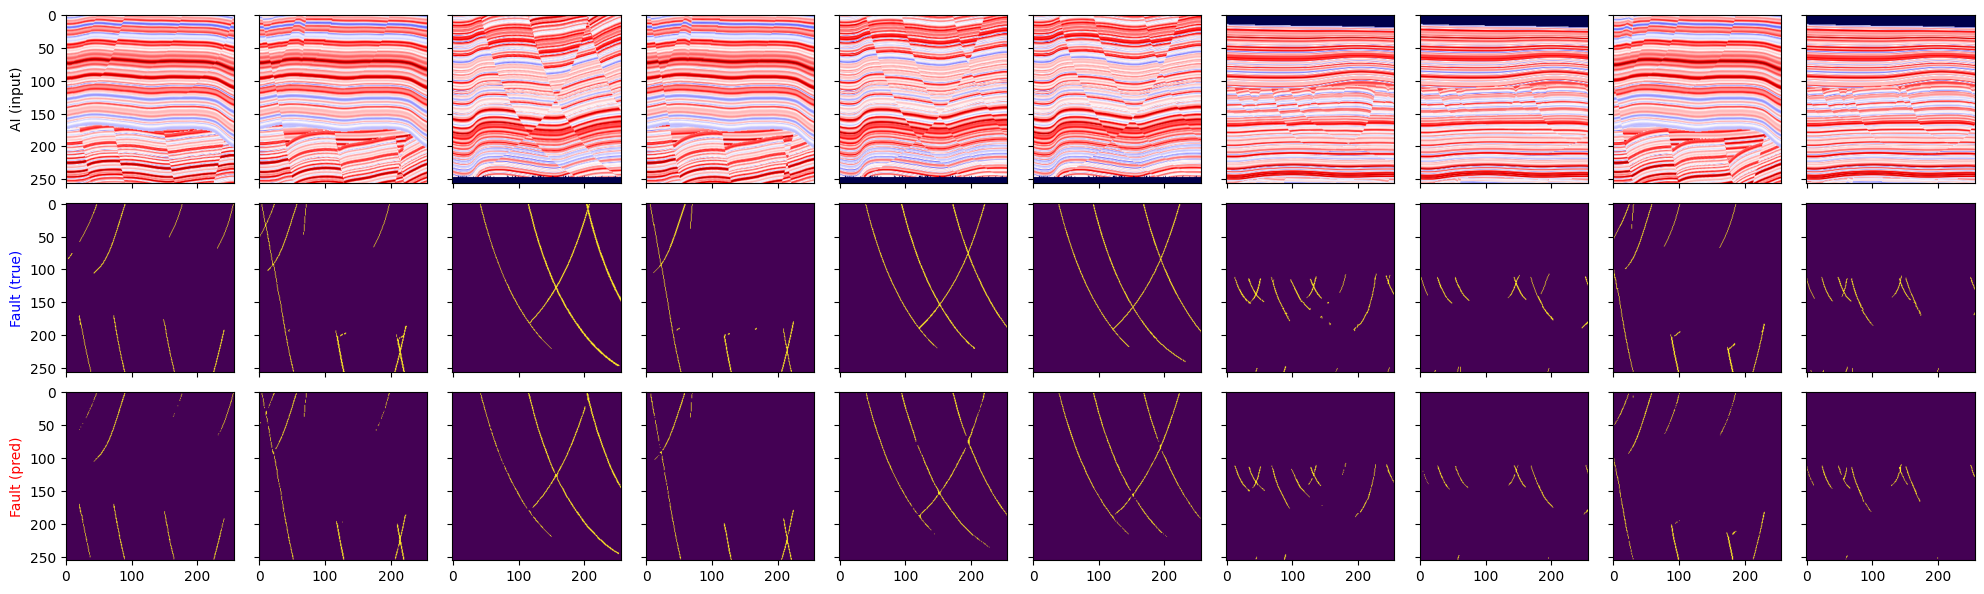

In [52]:
fig, axs = plt.subplots(3, 10, figsize=(20,6), sharex=True, sharey=True)
for j in range(10):
    k = j * 5
    ax1, ax2, ax3 = axs[:,j]
    ax1.imshow(X_test[k], cmap='seismic', vmin=0, vmax=1)
    ax2.imshow(y_test[k], vmin=0, vmax=1)
    ax3.imshow(y_test_pred[k], vmin=0, vmax=1)
    [a.set_ylabel(['AI (input)', 'Fault (true)', 'Fault (pred)'][i], color=['k','b','r'][i]) for i,a in enumerate(axs[:,0])]
plt.tight_layout()
plt.show()

In [107]:
r2_train = r2_score(y_train.reshape(n_train,-1), y_train_pred.reshape(n_train,-1))
r2_test = r2_score(y_test.reshape(n_test,-1), y_test_pred.reshape(n_test,-1))
print('R2       - train: {:.3f} | test: {:.3f}'.format(r2_train, r2_test))

mse_train = mse_metric(y_train.reshape(n_train,-1), y_train_pred.reshape(n_train,-1))
mse_test = mse_metric(y_test.reshape(n_test,-1), y_test_pred.reshape(n_test,-1))
print('MSE      - train: {:.3f} | test: {:.3f}'.format(mse_train, mse_test))

mae_train = mae_metric(y_train.reshape(n_train,-1), y_train_pred.reshape(n_train,-1))
mae_test = mae_metric(y_test.reshape(n_test,-1), y_test_pred.reshape(n_test,-1))
print('MAE      - train: {:.3f} | test: {:.3f}'.format(mae_train, mae_test))

ssim_train = structural_similarity(y_train.squeeze(), y_train_pred.squeeze(), data_range=1, multichannel=False)
ssim_test = structural_similarity(y_test.squeeze(), y_test_pred.squeeze(), data_range=1, multichannel=False)
print('SSIM     - train: {:.3f} | test: {:.3f}'.format(ssim_train, ssim_test))

f1_train = f1_score(y_train.reshape(n_train,-1), y_train_pred.reshape(n_train,-1), average='macro', zero_division=0)
f1_test = f1_score(y_test.reshape(n_test,-1), y_test_pred.reshape(n_test,-1), average='macro', zero_division=0)
print('F1       - train: {:.3f} | test: {:.3f}'.format(f1_train, f1_test))

accuracy_train = accuracy_score(y_train.reshape(n_train,-1), y_train_pred.reshape(n_train,-1))
accuracy_test = accuracy_score(y_test.reshape(n_test,-1), y_test_pred.reshape(n_test,-1))
print('Accuracy - train: {:.3f} | test: {:.3f}'.format(accuracy_train, accuracy_test))

R2       - train: 0.780 | test: 0.844
MSE      - train: 0.004 | test: 0.003
MAE      - train: 0.004 | test: 0.003
SSIM     - train: 0.916 | test: 0.921
F1       - train: 0.654 | test: 0.486
Accuracy - train: 0.002 | test: 0.000


***
## Fomel faults

In [109]:
ff = np.load('faults.npz')
data, labels, test = ff['data'], ff['labels'], ff['test']
n_data, n_dim = data.shape[0], data.shape[1]
print('Data: {} | Labels: {} | Test: {}'.format(data.shape, labels.shape, test.shape))

Data: (2000, 128, 128) | Labels: (2000, 128, 128) | Test: (100, 256, 640)


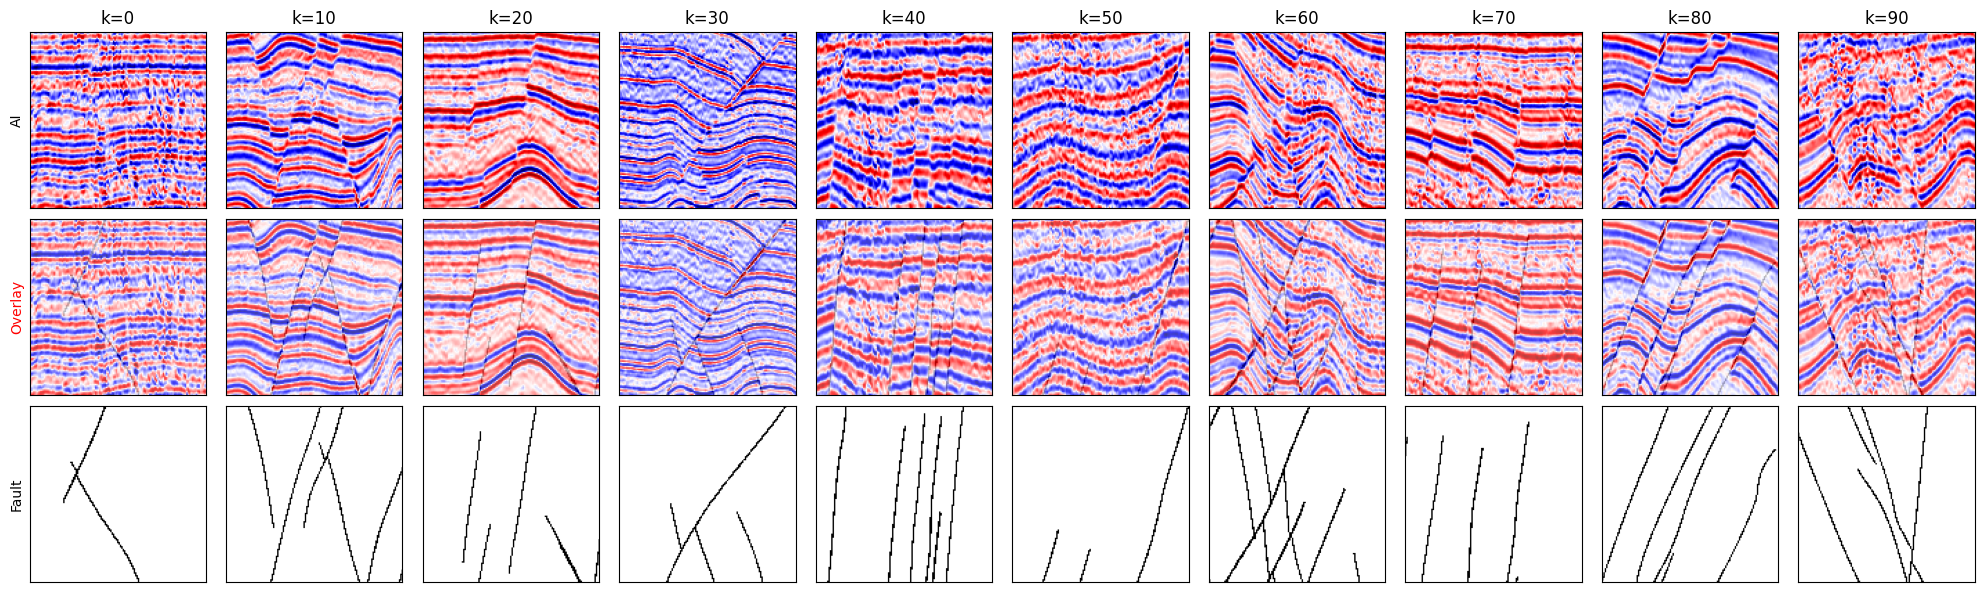

In [61]:
fig, axs = plt.subplots(3, 10, figsize=(20, 6), sharex=True, sharey=True)
for j in range(10):
    k = j * 10
    ax1, ax2, ax3 = axs[0, j], axs[1, j], axs[2, j]
    ax1.imshow(data[k], cmap='seismic')
    ax2.imshow(data[k], cmap='seismic')
    ax2.imshow(labels[k], cmap='binary', alpha=0.25)
    ax3.imshow(labels[k], cmap='binary')
    [a.set(xticks=[], yticks=[], title='k={}'.format(k) if i==0 else '') for i, a in enumerate(axs[:, j])]
    [a.set_ylabel(['AI','Overlay','Fault'][i], color=['k','r','k'][i]) for i, a in enumerate(axs[:,0])]
plt.tight_layout()
plt.show()

In [ ]:
X_new = (data - data.min()) / (data.max() - data.min())
X_new = np.expand_dims(X_new, axis=-1)
y_new = np.expand_dims(labels, axis=-1)

print('X_new: {} | min: {:.3f} | max: {:.3f} | mean: {:.3f}'.format(X_new.shape, X_new.min(), X_new.max(), X_new.mean()))
print('y_new: {} | min: {:.3f} | max: {:.3f} | mean: {:.3f}'.format(y_new.shape, y_new.min(), y_new.max(), y_new.mean()))

X_new: (2000, 128, 128, 1) | min: 0.000 | max: 1.000 | mean: 0.469
y_new: (2000, 128, 128, 1) | min: 0.000 | max: 1.000 | mean: 0.034


In [70]:
y_new_pred = ae.predict(X_new, verbose=0).squeeze()
y_new_pred = (y_new_pred - y_new_pred.min()) / (y_new_pred.max() - y_new_pred.min())
y_new_pred = np.where(y_new_pred > 0.5, 1, 0)
print('New pred - min: {:.3f} | max: {:.3f} | mean: {:.3f}'.format(y_new_pred.min(), y_new_pred.max(), y_new_pred.mean()))

New pred - min: 0.000 | max: 1.000 | mean: 0.001


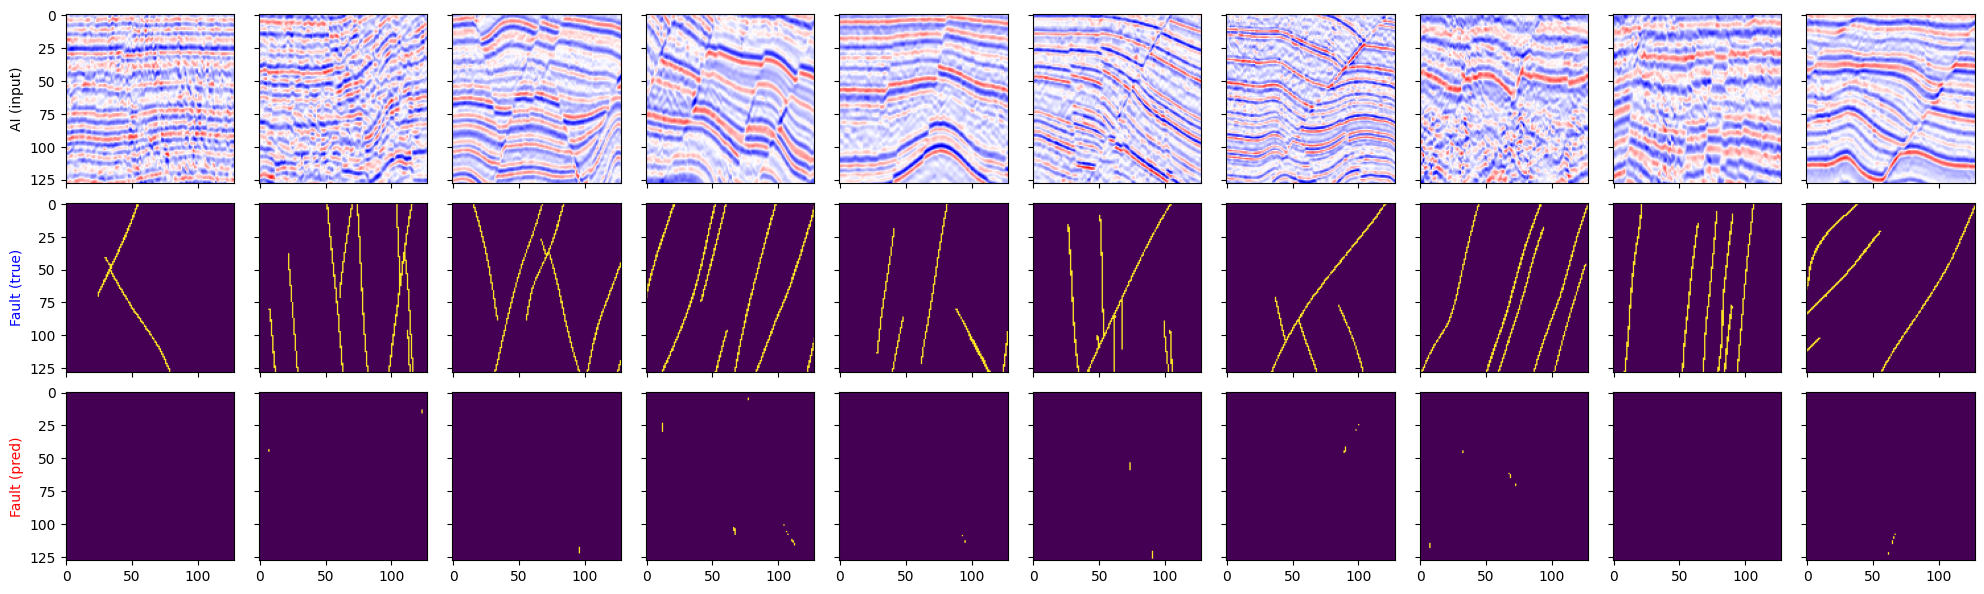

In [71]:
fig, axs = plt.subplots(3, 10, figsize=(20,6), sharex=True, sharey=True)
for j in range(10):
    k = j * 5
    ax1, ax2, ax3 = axs[:,j]
    ax1.imshow(X_new[k], cmap='seismic', vmin=0, vmax=1)
    ax2.imshow(y_new[k], vmin=0, vmax=1)
    ax3.imshow(y_new_pred[k], vmin=0, vmax=1)
    [a.set_ylabel(['AI (input)', 'Fault (true)', 'Fault (pred)'][i], color=['k','b','r'][i]) for i,a in enumerate(axs[:,0])]
plt.tight_layout()
plt.show()

In [111]:
new_r2 = r2_score(y_new.reshape(n_data,-1), y_new_pred.reshape(n_data,-1))
new_mse = mse_metric(y_new.reshape(n_data,-1), y_new_pred.reshape(n_data,-1))
new_mae = mae_metric(y_new.reshape(n_data,-1), y_new_pred.reshape(n_data,-1))
new_ssim = structural_similarity(y_new.squeeze(), y_new_pred.squeeze(), data_range=1, multichannel=False)
new_f1 = f1_score(y_new.reshape(n_data,-1), y_new_pred.reshape(n_data,-1), average='macro', zero_division=0)
new_accuracy = accuracy_score(y_new.reshape(n_data,-1), y_new_pred.reshape(n_data,-1))
print('R2: {:.3f} | MSE: {:.3f} | MAE: {:.3f} | SSIM: {:.3f} | F1: {:.3f} | Accuracy: {:.3f}'.format(new_r2, new_mse, new_mae, new_ssim, new_f1, new_accuracy))

R2: -0.042 | MSE: 0.034 | MAE: 0.034 | SSIM: 0.262 | F1: 0.035 | Accuracy: 0.000


***
# END